In [1]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

In [2]:
imagesDirectory = '../data/images/'

In [3]:
#images = [f for f in listdir(imagesDirectory) if isfile(join(imagesDirectory, f)) and f.endswith('.jpg')]

In [4]:
exampleIDs = ['zbz-990109042670205508',
             'zbz-990109043130205508']

In [5]:
exampleImages = [d + '.jpg' for d in exampleIDs]

In [6]:
exampleImage = exampleImages[-1]

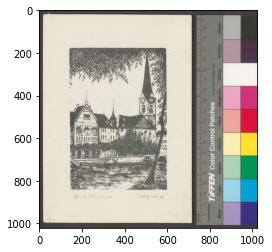

In [7]:
image = cv2.imread(join(imagesDirectory, exampleImage))
image = image[:,:,::-1]
plt.imshow(Image.fromarray(image))

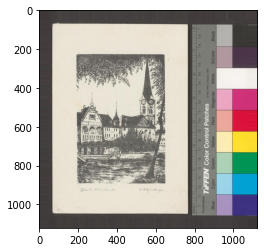

In [8]:
extension = 50
extendedImage = cv2.copyMakeBorder(image,extension,extension,extension,extension,cv2.BORDER_REPLICATE)
plt.imshow(Image.fromarray(extendedImage))

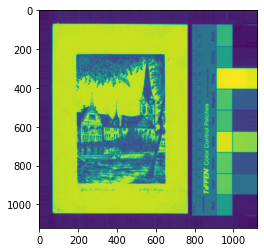

In [9]:
gray = cv2.cvtColor(extendedImage.copy(), cv2.COLOR_RGB2GRAY)
gray = cv2.blur(gray, (5, 5))
plt.imshow(Image.fromarray(gray))

In [10]:
# Check brighness of upper left corner
# if bright use cv2.THRESH_BINARY_INV
# if not use cv2.THRESH_BINARY
padding = 5
if gray[extension+padding][extension+padding] > 127:
    thresholdMethod = cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
    print("Image is bright")
else:
    thresholdMethod = cv2.THRESH_BINARY+cv2.THRESH_OTSU
    print("Image is dark")

Image is dark


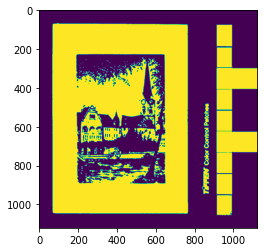

In [11]:
ret, thresh = cv2.threshold(gray,0,255,thresholdMethod)
plt.imshow(Image.fromarray(thresh))

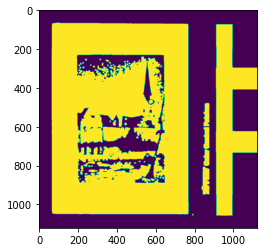

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilate = cv2.dilate(thresh, kernel, iterations=3)
plt.imshow(Image.fromarray(dilate))

In [13]:
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


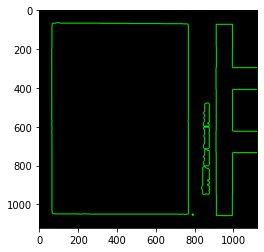

In [14]:
img_contours = np.zeros(extendedImage.shape)
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
plt.imshow(img_contours)

In [15]:
areas = [cv2.contourArea(c) for c in contours]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


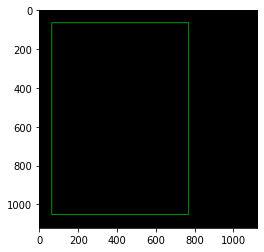

In [17]:
cnt=contours[max_index]
x,y,w,h = cv2.boundingRect(cnt)

img = np.zeros(extendedImage.shape)
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img)

In [18]:
# Check if detected area includes colour bar
# Take the two largest regions and pick the one that is more square

In [19]:
indicesOfTwoLargestContours = [areas.index(x) for x in sorted(areas, reverse=True)[:2]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.402560455192034
4.560185185185185


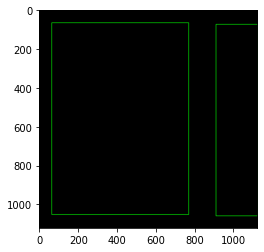

In [20]:
img = np.zeros(extendedImage.shape)
for i in indicesOfTwoLargestContours:
    x,y,w,h = cv2.boundingRect(contours[i])
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    print(max(w,h)/min(w,h))
plt.imshow(img)

In [21]:
ratios = []
for i in indicesOfTwoLargestContours:
    x,y,w,h = cv2.boundingRect(contours[i])
    ratios.append(max(w,h)/min(w,h))

In [22]:
min_ratio_index = np.argmin(ratios)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


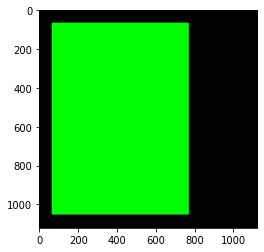

In [23]:
img = np.zeros(extendedImage.shape)
x,y,w,h = cv2.boundingRect(contours[indicesOfTwoLargestContours[min_ratio_index]])
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),-1)
plt.imshow(img)